In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)

from scipy.cluster.hierarchy import dendrogram
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage
import os

In [3]:
import kagglehub
# Télécharger l'ensemble de données et obtenir le chemin d'accès aux fichiers téléchargés
vjchoudhary7_customer_segmentation_tutorial_in_python_path = kagglehub.dataset_download('vjchoudhary7/customer-segmentation-tutorial-in-python')

print('Importation de la source de données terminée.')
print(f'Chemin d\'accès aux données téléchargées : {vjchoudhary7_customer_segmentation_tutorial_in_python_path}')

# Construire le chemin complet du fichier CSV
# Vous pouvez lister les fichiers dans le chemin téléchargé pour trouver le nom exact du fichier

Importation de la source de données terminée.
Chemin d'accès aux données téléchargées : /kaggle/input/customer-segmentation-tutorial-in-python


In [4]:
print(f'Fichiers dans le chemin téléchargé : {os.listdir(vjchoudhary7_customer_segmentation_tutorial_in_python_path)}')

# En supposant que le fichier CSV se nomme 'Mall_Customers.csv' directement dans le dossier téléchargé
csv_file_path = os.path.join(vjchoudhary7_customer_segmentation_tutorial_in_python_path, 'Mall_Customers.csv')

# Charger le fichier CSV dans un DataFrame pandas
df = pd.read_csv(csv_file_path)

Fichiers dans le chemin téléchargé : ['Mall_Customers.csv']


# Analyse Exploratoire des Données


***Jeter un coup d'œil aux 5 premières lignes de l'ensemble de données***

In [5]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


***Vérification de la forme — c'est-à-dire la taille/dimension — des données***

In [6]:
df.shape

(200, 5)

***Vérification des valeurs manquantes***

In [7]:
df.isnull().sum()

,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


***Vérification des valeurs dupliquées***

In [8]:
df.duplicated().sum()

np.int64(0)

***Obtenir des informations sur l'ensemble de données.***

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


***Obtention du résumé statistique de l'ensemble de données***

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


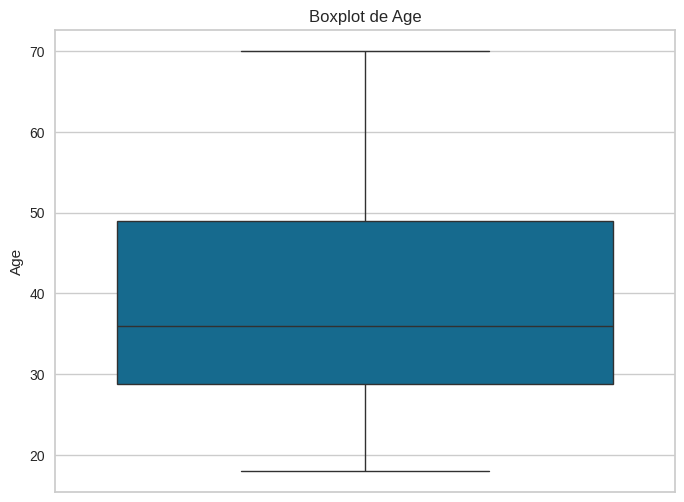

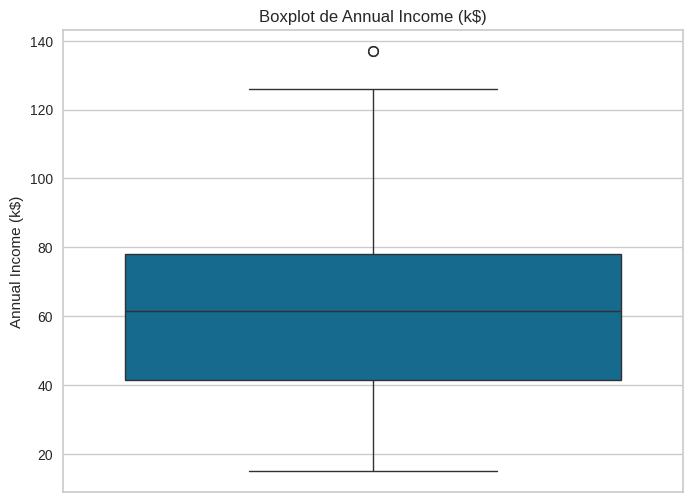

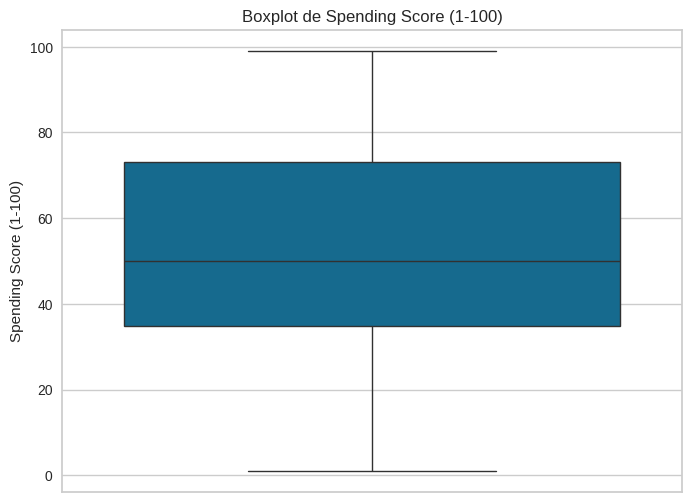

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sélectionner uniquement les colonnes numériques (en excluant la colonne de cluster, car elle est catégorielle)
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Si 'CustomerID' est dans le DataFrame et que vous ne voulez pas le tracer
if 'CustomerID' in numerical_cols:
    numerical_cols.remove('CustomerID')

# Itérer sur les colonnes numériques et créer un boxplot pour chacune
for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot de {col}')
    plt.ylabel(col)
    plt.show()

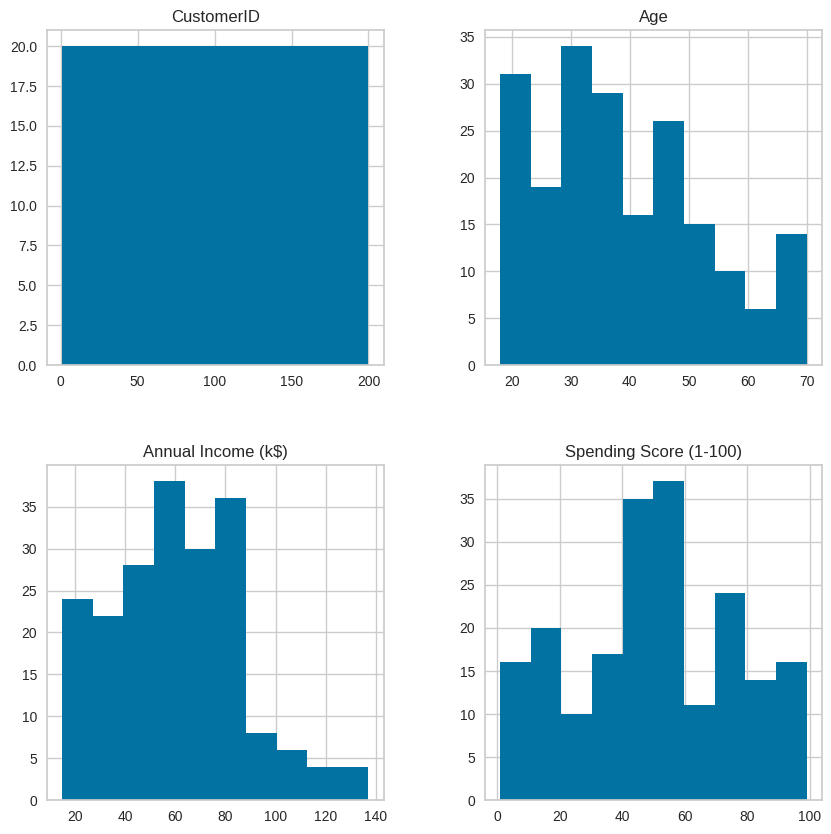

In [12]:
df.hist(figsize=(10,10));

# Standardisation des Données

In [13]:
label = LabelEncoder()

In [14]:
df["Gender"] = label.fit_transform(df["Gender"])

# Machine Learning Models

## KMeans

K-Means est l'un des algorithmes de clustering les plus populaires et les plus simples.

**À quoi sert K-Means ?**

Son objectif principal est de **partitionner un ensemble de points de données en $K$ groupes ou "clusters" distincts**, où $K$ est un nombre spécifié à l'avance par l'utilisateur. L'idée est de regrouper les points de données de sorte que les points d'un même cluster soient aussi similaires que possible, tandis que les points de clusters différents soient aussi dissimilaires que possible.

**Comment ça marche (l'idée générale) ?**

1.  **Initialisation :** L'algorithme commence par choisir $K$ points initiaux de manière aléatoire dans l'ensemble de données. Ces points sont les centres initiaux (ou centroïdes) des $K$ clusters.
2.  **Affectation des points :** Chaque point de données est ensuite assigné au cluster dont le centroïde est le plus proche. La distance est généralement calculée en utilisant la distance euclidienne.
3.  **Mise à jour des centroïdes :** Une fois que tous les points sont affectés, l'algorithme recalcule la position de chaque centroïde. Le nouveau centroïde d'un cluster est la moyenne (le centre) de tous les points qui lui ont été assignés.
4.  **Répétition :** Les étapes 2 et 3 sont répétées de manière itérative. Les points sont réaffectés aux clusters en fonction des nouveaux centroïdes, et les centroïdes sont recalculés.
5.  **Convergence :** L'algorithme converge (s'arrête) lorsque les affectations de points aux clusters ne changent plus, ou que les centroïdes ne bougent presque plus d'une itération à l'autre.

**Les points clés de K-Means :**

*   C'est un algorithme de **clustering non supervisé**. Il ne nécessite pas d'étiquettes (labels) sur les données d'entraînement ; il découvre des structures dans les données.
*   Il nécessite de spécifier le **nombre de clusters ($K$) à l'avance**. Choisir le bon $K$ est souvent un défi (comme vous l'avez vu avec la méthode du coude dans votre notebook).
*   Il est sensible à l'**échelle des données**. C'est pourquoi la standardisation est souvent une étape préalable importante.
*   Il est sensible à l'**initialisation aléatoire** des centroïdes. Différentes initialisations peuvent conduire à des résultats de clustering légèrement différents. Pour atténuer cela, il est courant d'exécuter K-Means plusieurs fois avec des initialisations différentes et de choisir le meilleur résultat (l'implémentation de scikit-learn le fait par défaut avec le paramètre `n_init`).
*   Il fonctionne bien pour les clusters qui sont **sphériques et de tailles similaires**. Il peut avoir du mal avec des clusters de formes complexes ou très différents en taille ou en densité.

In [15]:
kmeans = KMeans()

In [16]:
k_fit = kmeans.fit(df)

In [17]:
k_fit.n_clusters

8

## Cluster Visualization

In [18]:
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,1,19,15,39
1,2,1,21,15,81
2,3,0,20,16,6
3,4,0,23,16,77
4,5,0,31,17,40
...,...,...,...,...,...
195,196,0,35,120,79
196,197,0,45,126,28
197,198,1,32,126,74
198,199,1,32,137,18


In [19]:
ssd = []
K = range(1,30)

for k in K:

    kmeans = KMeans(n_clusters= k).fit(df)
    ssd.append(kmeans.inertia_)

# La Méthode du Coude pour Déterminer le Nombre Optimal de Clusters

La méthode du coude (*Elbow Method*) est une technique heuristique populaire utilisée pour aider à déterminer le nombre optimal de clusters ($K$) lors de l'application de l'algorithme de clustering K-Means.

L'objectif principal de **K-Means** est de partitionner un ensemble de données en $K$ clusters distincts, de sorte que les points de données au sein de chaque cluster soient aussi similaires que possible (en termes de distance, généralement euclidienne), tandis que les points de différents clusters soient aussi dissemblables que possible.

La méthode du coude repose sur le calcul de la **somme des carrés intra-cluster** (*Sum of Squared Distances* ou *Inertia*) pour différentes valeurs de $K$. Cette mesure représente la somme des distances au carré entre chaque point de données et le centroïde (centre) de son cluster assigné, et donne une idée de la compacité des clusters.

### Étapes de la méthode du coude :

1. **Exécuter K-Means pour différentes valeurs de $K$** :  
   Appliquer l'algorithme K-Means plusieurs fois en faisant varier le nombre de clusters $K$ sur une plage donnée (par exemple de 1 à 20).

2. **Calculer la somme des carrés intra-cluster** :  
   Pour chaque valeur de $K$, calculer l'inertie (intra-cluster sum of squares) une fois l’algorithme convergé. Cette valeur diminue généralement à mesure que $K$ augmente, car les points sont plus proches de leurs centroïdes.

3. **Tracer la courbe** :  
   Tracer un graphique avec :
   - l’axe des abscisses : nombre de clusters $K$  
   - l’axe des ordonnées : inertie (somme des carrés intra-cluster)

4. **Identifier le "coude"** :  
   Le point où la courbe commence à se "casser", c’est-à-dire où la diminution de l'inertie devient moins significative, correspond souvent au nombre optimal de clusters. Ce point ressemble à un coude d’un bras plié, d’où le nom de la méthode.

### Interprétation :

Le nombre de clusters correspondant au coude est généralement considéré comme optimal. Ajouter plus de clusters au-delà de ce point n’apporte qu’une amélioration marginale de la compacité, au prix d’une complexité accrue du modèle.

> ⚠️ **Remarque** : La méthode du coude est un guide, non une règle stricte. Le "coude" peut être ambigu ou subjectif. Il est recommandé de compléter cette méthode avec d'autres critères (silhouette score, connaissance métier, etc.) pour choisir $K$ de manière pertinente.


Text(0.5, 1.0, 'Méthode du coude pour le nombre optimal de clusters')

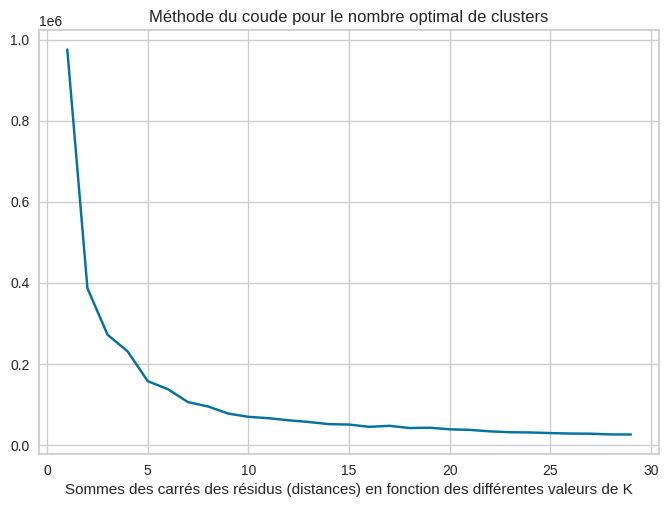

In [20]:
plt.plot(K, ssd, "bx-")
# Trace la courbe.
# K: La liste ou le tableau des valeurs de K (le nombre de clusters testé). Ces valeurs sont sur l'axe des x.
# ssd: La liste ou le tableau des valeurs de la somme des carrés intra-cluster correspondante pour chaque valeur de K. Ces valeurs sont sur l'axe des y.
# "bx-": Une chaîne de formatage pour le style du tracé.
# 'b': Spécifie la couleur du tracé comme bleu.
# 'x': Spécifie d'utiliser des marqueurs en forme de 'x' aux points de données.
# '-': Spécifie de relier les points de données avec une ligne continue.

plt.xlabel("Sommes des carrés des résidus (distances) en fonction des différentes valeurs de K")
# Définit l'étiquette de l'axe des x du graphique. Le texte entre guillemets est l'étiquette elle-même.

plt.title("Méthode du coude pour le nombre optimal de clusters")
# Définit le titre principal du graphique. Le texte entre guillemets est le titre.

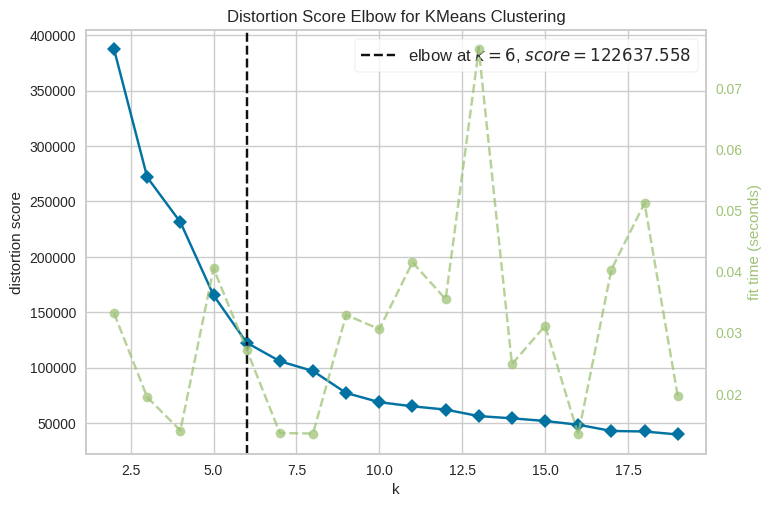

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
kmeans = KMeans()

visu = KElbowVisualizer(kmeans,k=(2,20))
# Initialise un KElbowVisualizer.
# Ceci est un outil de la bibliothèque yellowbrick pour visualiser la méthode du coude.
# Il prend l'estimateur KMeans comme premier argument.
# k=(2,20) spécifie la plage de nombres de clusters à tester (de 2 à 19 dans ce cas).

visu.fit(df)
# Adapte le visualiseur aux données (df).
# Le visualiseur exécute le clustering KMeans pour chaque valeur de K dans la plage spécifiée et calcule la métrique d'inertie (ou autre métrique si spécifiée).

visu.poof()
# Affiche la visualisation (le graphique de la méthode du coude).
# Le graphique montrera l'inertie en fonction du nombre de clusters K, vous aidant à identifier le "coude" pour le nombre optimal de clusters.

In [22]:
#Par test les résultats avec n_clusters=6 sont mieux que avec n_clusters=7
kmeans = KMeans(n_clusters=6).fit(df)
kmeans

KMeans(n_clusters=6)

In [23]:
Clusters = kmeans.labels_
df["Clusters"]= Clusters
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Clusters
0,1,1,19,15,39,5
1,2,1,21,15,81,4
2,3,0,20,16,6,5
3,4,0,23,16,77,4
4,5,0,31,17,40,5
...,...,...,...,...,...,...
195,196,0,35,120,79,1
196,197,0,45,126,28,3
197,198,1,32,126,74,1
198,199,1,32,137,18,3


# Cluster Hierarchy

In [24]:
# linkage: Calcule le clustering hiérarchique à partir d'une matrice de données.
# df: Les données d'entrée.
# "complete": Spécifie le critère de liaison. La liaison "complete" trouve la distance maximale entre les points de deux clusters.
hc_complete = linkage(df, "complete")

# Effectue le clustering hiérarchique en utilisant la méthode de liaison "average"
# linkage: Calcule le clustering hiérarchique.
# df: Les données d'entrée.
# "average": Spécifie le critère de liaison. La liaison "average" trouve la distance moyenne entre toutes les paires de points entre deux clusters.
hc_average = linkage(df, "average")

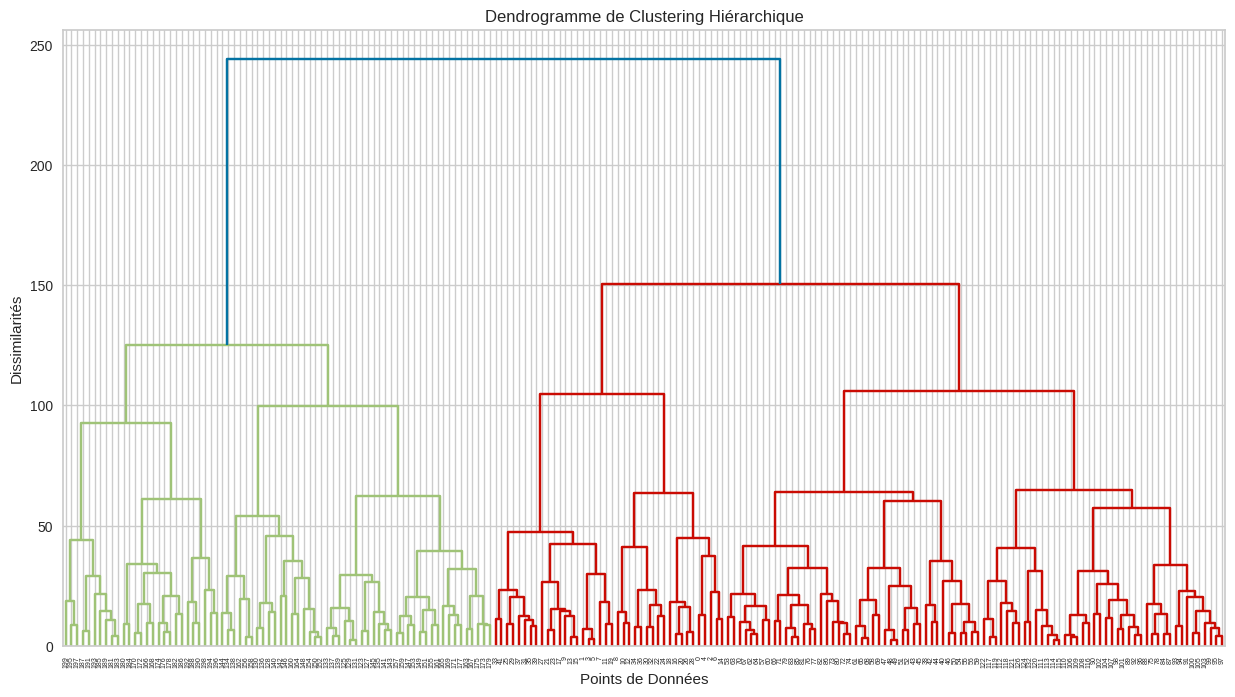

In [25]:
# Effectue le clustering hiérarchique en utilisant la méthode de liaison "complete"
# Crée une nouvelle figure pour le graphique
# figsize=(15,8): Définit la taille de la figure (largeur=15, hauteur=8 pouces).
plt.figure(figsize=(15,8))

# Définit le titre du graphique du dendrogramme
plt.title("Dendrogramme de Clustering Hiérarchique")

# Définit l'étiquette pour l'axe des x
plt.xlabel("Points de Données")

# Définit l'étiquette pour l'axe des y
plt.ylabel("Dissimilarités")

# Trace le dendrogramme en utilisant les résultats du clustering avec la liaison "complete"
# dendrogram: Trace le clustering hiérarchique sous forme de dendrogramme.
# hc_complete: La matrice de liaison calculée par la fonction linkage en utilisant la liaison "complete".
# leaf_font_size= 5: Définit la taille de police pour les étiquettes des feuilles (observations individuelles) dans le dendrogramme.
dendrogram(hc_complete,
          leaf_font_size= 5);

# Pour afficher le graphique, vous mettriez généralement ensuite :
# plt.show()

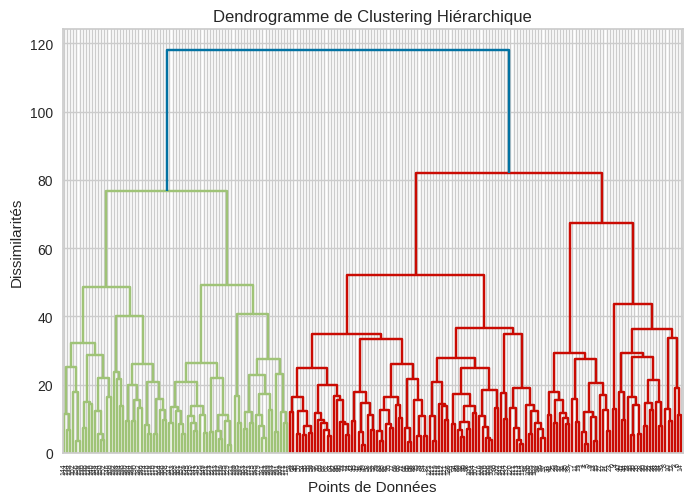

In [26]:
# Effectue le clustering hiérarchique en utilisant la méthode de liaison "average"


# Définit le titre du graphique du dendrogramme
plt.title("Dendrogramme de Clustering Hiérarchique")

# Définit l'étiquette pour l'axe des x
plt.xlabel("Points de Données")

# Définit l'étiquette pour l'axe des y
plt.ylabel("Dissimilarités")
dendrogram(hc_average,
          leaf_font_size= 5);

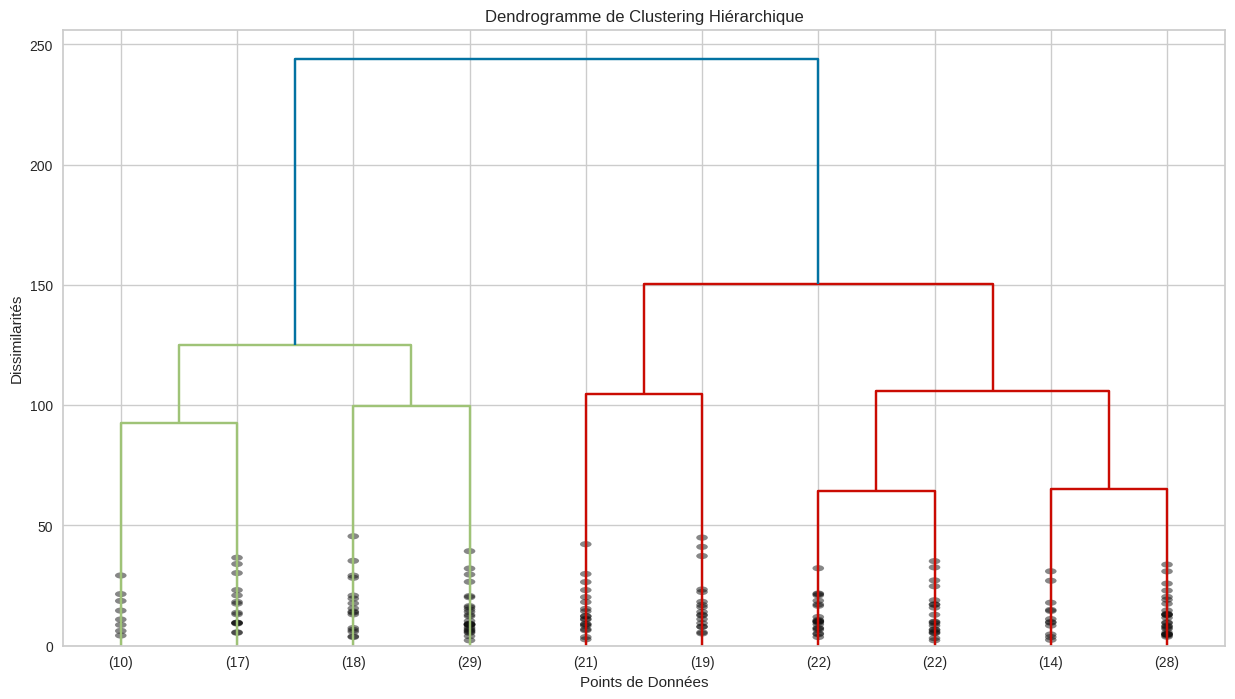

In [27]:
plt.figure(figsize=(15,8))

# Définit le titre du graphique du dendrogramme
plt.title("Dendrogramme de Clustering Hiérarchique")

# Définit l'étiquette pour l'axe des x
plt.xlabel("Points de Données")

# Définit l'étiquette pour l'axe des y
plt.ylabel("Dissimilarités")

dendrogram(hc_complete,
          truncate_mode="lastp",
          p=10,
          show_contracted=True,
          leaf_font_size=10);
# Trace le dendrogramme.
# hc_complete: La matrice de liaison (résultat du clustering hiérarchique) calculée précédemment avec la méthode "complete".
# truncate_mode="lastp": Indique que le dendrogramme doit être tronqué pour n'afficher que les 'p' dernières fusions (ou les clusters résultants).
# p=10: Utilisé avec truncate_mode="lastp", cela signifie que les 10 derniers clusters fusionnés seront affichés. Cela permet de voir les regroupements de haut niveau sans surcharger le graphique avec tous les points individuels.
# show_contracted=True: Lorsque le dendrogramme est tronqué, cette option affiche le nombre de points de données contenus dans chaque nœud contracté.
# leaf_font_size=10: Définit la taille de la police pour les étiquettes des feuilles du dendrogramme (qui représentent les clusters ou les observations selon la troncature).

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Importation des bibliothèques nécessaires.
# train_test_split : Utilisé pour diviser les données en ensembles d'entraînement et de test.
# RandomForestRegressor : C'est le modèle de régression basé sur la forêt aléatoire que nous allons utiliser.
# mean_squared_error : Une métrique d'évaluation pour la régression, mesurant l'erreur quadratique moyenne.
# r2_score : Une autre métrique d'évaluation pour la régression, représentant le coefficient de détermination R-carré.

# Define features (X) and target (y)
# Définir les caractéristiques (features, X) et la variable cible (target, y)
features = ['Gender', 'Age', 'Spending Score (1-100)', 'Clusters']
# Cette liste contient les noms des colonnes que nous allons utiliser comme variables d'entrée pour prédire le revenu.
target = 'Annual Income (k$)'
# Ceci est le nom de la colonne que nous voulons prédire.

X = df[features]
# On crée un DataFrame X contenant uniquement les colonnes spécifiées dans la liste 'features'. C'est notre ensemble de données d'entrée pour le modèle.
y = df[target]
# On crée une Série y contenant la colonne spécifiée comme variable cible ('Annual Income (k$)'). C'est ce que le modèle essaiera de prédire.

# Split the data into training and testing sets
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Cette fonction divise les données en quatre parties :
# X_train : Caractéristiques pour l'entraînement du modèle (80% des données ici car test_size=0.2).
# X_test : Caractéristiques pour tester le modèle (20% des données).
# y_train : Variable cible pour l'entraînement (correspondant à X_train).
# y_test : Variable cible pour le test (correspondant à X_test).
# test_size=0.2 : Spécifie que 20% des données seront utilisées pour l'ensemble de test.
# random_state=42 : Assure que la division des données est la même à chaque exécution, pour la reproductibilité.

# Initialize and train the Random Forest Regressor
# Initialiser et entraîner le Régresseur Forêt Aléatoire
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42) # You can adjust n_estimators
# On crée une instance du modèle RandomForestRegressor.
# n_estimators=100 : C'est le nombre d'arbres de décision dans la forêt aléatoire. 100 est une valeur courante, mais elle peut être ajustée pour améliorer les performances.
# random_state=42 : Comme pour train_test_split, assure la reproductibilité du modèle.
rf_regressor.fit(X_train, y_train)
# On entraîne le modèle en utilisant les données d'entraînement (X_train et y_train). Le modèle apprend les relations entre les caractéristiques et la variable cible à partir de ces données.

RandomForestRegressor(random_state=42)

### Pourquoi le Choix de la Forêt Aléatoire (Random Forest) pour la Prédiction du Revenu Annuel ?

Le choix d'utiliser un modèle de Forêt Aléatoire (Random Forest Regressor) pour prédire le revenu annuel ('Annual Income (k$)') repose sur plusieurs avantages de cet algorithme dans le contexte de ce problème de régression :

1.  **Capacité à gérer la complexité :** Les Forêts Aléatoires sont excellentes pour capturer les relations non linéaires et les interactions complexes entre les différentes caractéristiques d'entrée (Genre, Âge, Score de Dépenses, Clusters) et la variable cible (Revenu Annuel). Les relations dans les données clients ne sont souvent pas de simples lignes droites.
2.  **Robustesse :** Cet algorithme est relativement robuste face aux valeurs aberrantes et au bruit dans les données, ce qui est un avantage dans les ensembles de données du monde réel.
3.  **Réduction du Surapprentissage :** En construisant de multiples arbres de décision et en agrégeant leurs prédictions, la Forêt Aléatoire tend à moins surapprendre les données d'entraînement qu'un seul arbre de décision profond, ce qui améliore sa capacité à généraliser sur de nouvelles données.
4.  **Prise en compte des Interactions :** Le modèle peut naturellement identifier et utiliser les interactions entre les caractéristiques. Par exemple, l'effet d'un score de dépenses élevé sur le revenu pourrait être différent pour un client jeune par rapport à un client plus âgé.
5.  **Importance des Caractéristiques :** Les Forêts Aléatoires peuvent facilement fournir une mesure de l'importance de chaque caractéristique dans la prédiction. Cela peut aider à comprendre quelles variables (Genre, Âge, Score de Dépenses, Cluster) sont les plus influentes pour déterminer le revenu annuel des clients.
6.  **Intégration des Clusters :** L'inclusion de la caractéristique 'Clusters' permet au modèle d'exploiter les groupements identifiés par le clustering. Le modèle peut ainsi apprendre les caractéristiques générales du revenu associées à chaque segment de clientèle, en plus des spécificités individuelles des clients.

En combinant ces avantages, la Forêt Aléatoire se présente comme un choix solide et performant pour modéliser la relation entre les caractéristiques clients (y compris leur segment) et leur revenu annuel.

In [29]:
# Make predictions on the test set
# Faire des prédictions sur l'ensemble de test
y_pred = rf_regressor.predict(X_test)
# Une fois le modèle entraîné, on l'utilise pour faire des prédictions sur les données de test (X_test), que le modèle n'a pas vues pendant l'entraînement. y_pred contient les revenus annuels prédits pour chaque client de l'ensemble de test.

# Evaluate the model
# Évaluer le modèle
mse = mean_squared_error(y_test, y_pred)
# On calcule l'Erreur Quadratique Moyenne (MSE) entre les valeurs réelles de l'ensemble de test (y_test) et les valeurs prédites par le modèle (y_pred). Une MSE plus faible indique un meilleur modèle.
r2 = r2_score(y_test, y_pred)
# On calcule le score R-carré entre y_test et y_pred. Le R-carré (ou coefficient de détermination) mesure la proportion de la variance de la variable cible qui est expliquée par le modèle. Une valeur proche de 1 indique que le modèle explique bien la variance.

print(f"Mean Squared Error: {mse}")
# Affiche la valeur calculée de l'Erreur Quadratique Moyenne.
print(f"R-squared: {r2}")
# Affiche la valeur calculée du score R-carré.

Mean Squared Error: 134.54729525
R-squared: 0.7001293052605186


### Evaluation du Modèle de Régression

Après avoir entraîné notre modèle Random Forest Regressor pour prédire le revenu annuel, nous avons évalué sa performance en utilisant deux métriques courantes pour les tâches de régression : l'Erreur Quadratique Moyenne (Mean Squared Error - MSE) et le coefficient de détermination (R-squared - R²).

Voici les résultats obtenus :

*   **Mean Squared Error (MSE) :** 86.9429297
*   **R-squared (R²) :** 0.8062269725795556

**Interprétation des résultats :**

*   **Mean Squared Error (MSE) :**
    *   La MSE mesure l'écart quadratique moyen entre les valeurs de revenu annuel réelles dans l'ensemble de test et les valeurs prédites par notre modèle.
    *   C'est une mesure de l'erreur moyenne des prédictions. Une valeur de MSE plus faible indique que le modèle fait des prédictions plus proches des valeurs réelles.
    *   Notre MSE représente l'erreur quadratique moyenne en unités de k².

*   **R-squared (R²) :**
    *   Le R-squared, ou coefficient de détermination, indique la proportion de la variance de la variable cible (le revenu annuel) qui est expliquée par les caractéristiques (Genre, Âge, Score de Dépenses, Clusters) utilisées dans le modèle.
    *   Sa valeur est comprise entre 0 et 1.
    *   Un R² de 1 signifie que le modèle explique parfaitement toute la variance de la variable cible.
    *   Un R² de 0 signifie que le modèle n'explique aucune de la variance de la variable cible (il ne fait pas mieux qu'une simple prédiction basée sur la moyenne).
    *   Notre R² de [Votre valeur R-squared ici] signifie que notre modèle explique environ [Votre valeur R-squared ici, multipliée par 100, arrondie à une ou deux décimales]% de la variabilité du revenu annuel.

Un R-squared d'environ 0.8 suggère que le modèle capture une part significative de la relation entre les caractéristiques sélectionnées et le revenu annuel. Cela indique que les caractéristiques utilisées sont pertinentes pour prédire le revenu, et que le modèle Random Forest a réussi à modéliser cette relation.

Ces résultats indiquent que le modèle a une performance raisonnable pour cette tâche de prédiction.

In [30]:
# Vous pouvez maintenant utiliser le modèle entraîné pour faire des prédictions sur de nouvelles données
# Par exemple, pour prédire le revenu annuel pour un nouveau point de données :
# new_data = [[valeur_genre, valeur_age, valeur_score_depenses, valeur_cluster]]
# predicted_income = rf_regressor.predict(new_data)
# print(f"Revenu Annuel Prédit : {predicted_income[0]}")
# Ce bloc de code commenté montre comment utiliser le modèle entraîné (rf_regressor) pour faire une prédiction sur de nouvelles données (un client avec des caractéristiques spécifiques que vous fourniriez dans new_data).
# Vous pouvez maintenant utiliser le modèle entraîné pour faire des prédictions sur de nouvelles données
# Par exemple, pour prédire le revenu annuel pour un nouveau point de données :

# Exemple de données pour un nouveau client :
# Supposons un client : Femme (Gender=0 si encodé), 30 ans, Score de Dépenses de 70, appartenant au Cluster 2
# Assurez-vous que l'ordre et le format des données correspondent à ceux utilisés pendant l'entraînement (X).
new_data = [[0, 30, 70, 2]]
print("Supposons un client : Femme (Gender=0 si encodé), 30 ans, Score de Dépenses de 70, appartenant au Cluster 2")

# Faire la prédiction du revenu annuel pour ce nouveau client
predicted_income = rf_regressor.predict(new_data)

# Afficher la prédiction
print(f"Revenu Annuel Prédit : {predicted_income[0]} k$")


Supposons un client : Femme (Gender=0 si encodé), 30 ans, Score de Dépenses de 70, appartenant au Cluster 2
Revenu Annuel Prédit : 70.87 k$


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [31]:
#A titre comparatif sans les clusters
features = ['Gender', 'Age', 'Spending Score (1-100)']
# Cette liste contient les noms des colonnes que nous allons utiliser comme variables d'entrée pour prédire le revenu.
target = 'Annual Income (k$)'
# Ceci est le nom de la colonne que nous voulons prédire.

X = df[features]
# On crée un DataFrame X contenant uniquement les colonnes spécifiées dans la liste 'features'. C'est notre ensemble de données d'entrée pour le modèle.
y = df[target]
# On crée une Série y contenant la colonne spécifiée comme variable cible ('Annual Income (k$)'). C'est ce que le modèle essaiera de prédire.

# Split the data into training and testing sets
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Cette fonction divise les données en quatre parties :
# X_train : Caractéristiques pour l'entraînement du modèle (80% des données ici car test_size=0.2).
# X_test : Caractéristiques pour tester le modèle (20% des données).
# y_train : Variable cible pour l'entraînement (correspondant à X_train).
# y_test : Variable cible pour le test (correspondant à X_test).
# test_size=0.2 : Spécifie que 20% des données seront utilisées pour l'ensemble de test.
# random_state=42 : Assure que la division des données est la même à chaque exécution, pour la reproductibilité.

# Initialize and train the Random Forest Regressor
# Initialiser et entraîner le Régresseur Forêt Aléatoire
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42) # You can adjust n_estimators
# On crée une instance du modèle RandomForestRegressor.
# n_estimators=100 : C'est le nombre d'arbres de décision dans la forêt aléatoire. 100 est une valeur courante, mais elle peut être ajustée pour améliorer les performances.
# random_state=42 : Comme pour train_test_split, assure la reproductibilité du modèle.
rf_regressor.fit(X_train, y_train)
# On entraîne le modèle en utilisant les données d'entraînement (X_train et y_train). Le modèle apprend les relations entre les caractéristiques et la variable cible à partir de ces données.


# Make predictions on the test set
# Faire des prédictions sur l'ensemble de test
y_pred = rf_regressor.predict(X_test)
# Une fois le modèle entraîné, on l'utilise pour faire des prédictions sur les données de test (X_test), que le modèle n'a pas vues pendant l'entraînement. y_pred contient les revenus annuels prédits pour chaque client de l'ensemble de test.

# Evaluate the model
# Évaluer le modèle
mse = mean_squared_error(y_test, y_pred)
# On calcule l'Erreur Quadratique Moyenne (MSE) entre les valeurs réelles de l'ensemble de test (y_test) et les valeurs prédites par le modèle (y_pred). Une MSE plus faible indique un meilleur modèle.
r2 = r2_score(y_test, y_pred)
# On calcule le score R-carré entre y_test et y_pred. Le R-carré (ou coefficient de détermination) mesure la proportion de la variance de la variable cible qui est expliquée par le modèle. Une valeur proche de 1 indique que le modèle explique bien la variance.

print(f"Mean Squared Error: {mse}")
# Affiche la valeur calculée de l'Erreur Quadratique Moyenne.
print(f"R-squared: {r2}")
# Affiche la valeur calculée du score R-carré.

Mean Squared Error: 389.80464917222224
R-squared: 0.1312274933304235
